In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms

### Collect data

In [4]:
DATASET_ID = 'tachibana_mouse'

In [5]:
from avgn.visualization.projections import (
    scatter_projections,
    draw_projection_transitions,
)

In [6]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'mouse.pickle'

In [7]:
syllable_df = pd.read_pickle(df_loc)

In [8]:
syllable_df[:3]

,start_time,end_time,indv,indvi,key,audio,rate,spectrogram
0,1.9770,1.9863,ClnBALB124,0,ClnBALB124-4vsBALBfe,"[0.00012935064, 0.0003061041, 0.00011063961, -...",250000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,2.0774,2.0884,ClnBALB124,0,ClnBALB124-4vsBALBfe,"[-0.00011886793, -0.00011039264, -1.8826695e-0...",250000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,2.1985,2.2046,ClnBALB124,0,ClnBALB124-4vsBALBfe,"[-0.0001612896, 0.00070529454, 0.0003123867, -...",250000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [9]:
pd.DataFrame({i:[np.sum(syllable_df.indv == i)] for i in syllable_df.indv.unique()})

,ClnBALB124,Can3_1,Aco65_1,Aco59_2,Can15-1,Can9-1,Can16-1,BALB128
0,203,119,383,418,588,726,565,168


### subset dataframe
- there is some noise in labelling we want to remove

Text(0.5, 1.0, 'min')

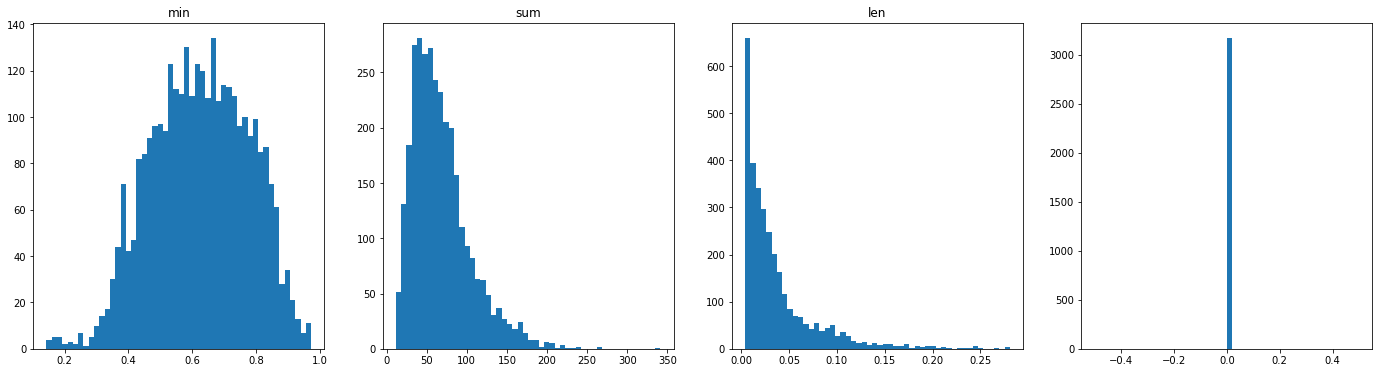

In [10]:
fig, axs = plt.subplots(ncols=4, figsize=(24,6))
axs[0].hist([np.max(i) for i in syllable_df.spectrogram.values], bins=50);axs[0].set_title('max')
axs[1].hist([np.sum(i) for i in syllable_df.spectrogram.values], bins=50);axs[1].set_title('sum')
axs[2].hist((syllable_df.end_time - syllable_df.start_time).values, bins = 50); axs[2].set_title('len')
axs[3].hist([np.min(i) for i in syllable_df.spectrogram.values], bins=50);axs[0].set_title('min')

In [13]:
indv_to_plot = [i for i in syllable_df.indv.unique() if np.sum(syllable_df.indv == i) > 100]
indv_to_plot

['ClnBALB124',
 'Can3_1',
 'Aco65_1',
 'Aco59_2',
 'Can15-1',
 'Can9-1',
 'Can16-1',
 'BALB128']

In [19]:
subset_df = syllable_df[
    syllable_df.indv.isin(indv_to_plot) & 
    np.array([np.max(i) > .3 for i in syllable_df.spectrogram.values])
]

In [31]:
specs = subset_df.spectrogram.values
specs = [i/np.max(i) for i in specs]
specs_flattened = flatten_spectrograms(specs)

In [40]:
len(syllable_df), len(subset_df)

(3170, 3130)

In [33]:
subset_df[:3]

,start_time,end_time,indv,indvi,key,audio,rate,spectrogram
0,1.9770,1.9863,ClnBALB124,0,ClnBALB124-4vsBALBfe,"[0.00012935064, 0.0003061041, 0.00011063961, -...",250000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,2.0774,2.0884,ClnBALB124,0,ClnBALB124-4vsBALBfe,"[-0.00011886793, -0.00011039264, -1.8826695e-0...",250000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,2.1985,2.2046,ClnBALB124,0,ClnBALB124-4vsBALBfe,"[-0.0001612896, 0.00070529454, 0.0003123867, -...",250000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


#### cluster and plot

In [34]:
np.shape(specs_flattened)

(3130, 2528)

In [35]:
fit = umap.UMAP(min_dist=0.25)

In [36]:
z  = list(fit.fit_transform(specs_flattened))

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


In [37]:
z = np.vstack(z)

In [38]:
np.shape(z)

(3130, 2)

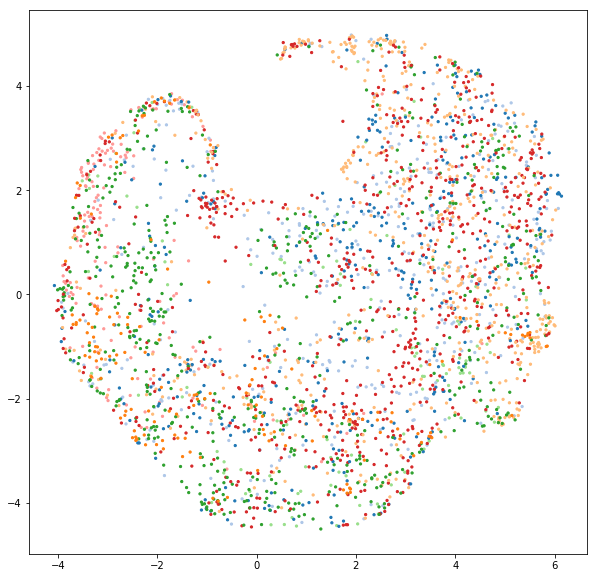

In [39]:
scatter_projections(projection=z, alpha=1, labels = subset_df.indv.values, s=5)